<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/04_transfer_learning_in_tensorflow_part1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patters for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similiar  to our own.
2. Can leverage a working neural network architecture which has already learned patters on similar data to our own, then we can adapt those patterns to our own data.

In [8]:
# Are we using GUP?
!nvidia-smi

Sat Jan 21 22:56:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-01-21 22:46:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.9MB/s    in 7.9s    

2023-01-21 22:46:21 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile

# unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent dat directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} direcotries and {len(filenames)} images in {dirpath}")

There are 2 direcotries and 0 images in 10_food_classes_10_percent
There are 10 direcotries and 0 images in 10_food_classes_10_percent/train
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/steak
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 direcotries and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 direcotr

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your model to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [6]:
# Create TensorBoard callback(funtionize because we need to create new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

and

https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5


In [9]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
effnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
# Import tools :)
import pathlib
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [23]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [24]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
# Compile our Resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [26]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230121-234854
Epoch 1/5
24/24 [==============================] - 19s 678ms/step - loss: 1.9069 - accuracy: 0.3840 - val_loss: 1.1887 - val_accuracy: 0.6300
Epoch 2/5
24/24 [==============================] - 15s 650ms/step - loss: 0.9062 - accuracy: 0.7280 - val_loss: 0.8530 - val_accuracy: 0.7180
Epoch 3/5
24/24 [==============================] - 15s 648ms/step - loss: 0.6299 - accuracy: 0.8267 - val_loss: 0.7524 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 15s 655ms/step - loss: 0.4791 - accuracy: 0.8773 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 5/5
24/24 [==============================] - 15s 649ms/step - loss: 0.3846 - accuracy: 0.9187 - val_loss: 0.6897 - val_accuracy: 0.7692


Wow!

That. Is. Increadible. Our transfer learning feature extraction model out performed ALL of the previous models we build by hand... (substantially) and quicker training time AND with only 10% of training examples.

In [20]:
# Let create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plot of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

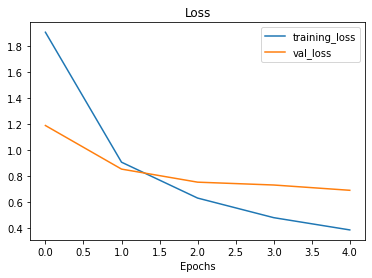

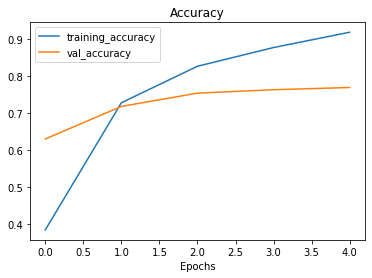

In [27]:
plot_loss_curves(history_resnet)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [28]:
# Create EfficientNetB0 feature extraction model 
effnet_model = create_model(effnet_url)

In [29]:
# Compile the model
effnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=Adam(),
                     metrics=["accuracy"])

In [30]:
# Fit EfficientNetB0 model
history_effnet = effnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="effnetb0"))

Saving TensorBoard log files to: tensorflow_hub/effnetb0/20230121-235809
Epoch 1/5
24/24 [==============================] - 24s 679ms/step - loss: 1.8611 - accuracy: 0.4200 - val_loss: 1.2831 - val_accuracy: 0.7292
Epoch 2/5
24/24 [==============================] - 15s 643ms/step - loss: 1.0648 - accuracy: 0.7653 - val_loss: 0.8631 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 14s 611ms/step - loss: 0.7664 - accuracy: 0.8333 - val_loss: 0.6992 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 14s 618ms/step - loss: 0.6181 - accuracy: 0.8547 - val_loss: 0.6076 - val_accuracy: 0.8580
Epoch 5/5
24/24 [==============================] - 14s 615ms/step - loss: 0.5201 - accuracy: 0.8880 - val_loss: 0.5552 - val_accuracy: 0.8668


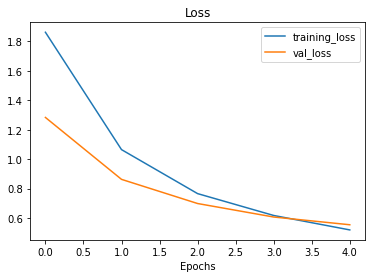

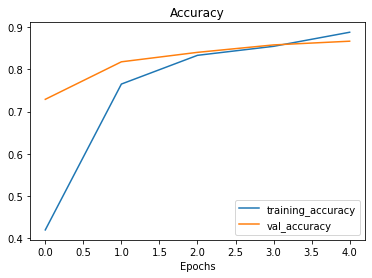

In [31]:
plot_loss_curves(history_effnet)

In [35]:
effb7_url = "https://tfhub.dev/google/efficientnet/b7/feature-vector/1"

In [36]:
effb7_model = create_model(effb7_url,
                           num_classes=train_data_10_percent.num_classes)

In [37]:
effb7_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=Adam(),
                    metrics=["accuracy"])

effb7_history = effb7_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                      experiment_name="efficientnetb7"))

Saving TensorBoard log files to: tensorflow_hub/efficientnetb7/20230122-002046
Epoch 1/5
24/24 [==============================] - 50s 2s/step - loss: 1.6078 - accuracy: 0.5373 - val_loss: 0.9784 - val_accuracy: 0.7684
Epoch 2/5
24/24 [==============================] - 34s 1s/step - loss: 0.8048 - accuracy: 0.8040 - val_loss: 0.6795 - val_accuracy: 0.8368
Epoch 3/5
24/24 [==============================] - 35s 1s/step - loss: 0.5872 - accuracy: 0.8560 - val_loss: 0.5803 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 35s 1s/step - loss: 0.4837 - accuracy: 0.8893 - val_loss: 0.5342 - val_accuracy: 0.8460
Epoch 5/5
24/24 [==============================] - 35s 2s/step - loss: 0.4126 - accuracy: 0.9080 - val_loss: 0.4982 - val_accuracy: 0.8552


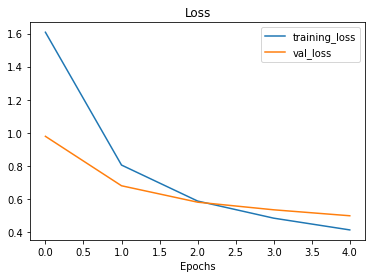

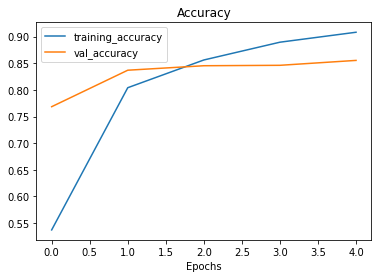

In [38]:
plot_loss_curves(effb7_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patters of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, you experiments are public. So if you're running private experiments (things you don't want others see) do not upload them to TensorBoard.dev.

In [40]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNetV250 vs EfficientNetB7" \
  --description "Compering three different TF Hub feature extraction model architectures using 10% of the training data." \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=HV9m7Phe7zoL89v9rWOIKXjwpKkVzd&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/reNBGyJTR8Sy8qU5OGuw4A/

In [41]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/reNBGyJTR8Sy8qU5OGuw4A/
	Name                 EfficientNetB0 vs ResNetV250 vs EfficientNetB7
	Description          Compering three different TF Hub feature extraction model architectures using 10% of the training data.
	Id                   reNBGyJTR8Sy8qU5OGuw4A
	Created              2023-01-22 00:50:57 (9 minutes ago)
	Updated              2023-01-22 00:51:13 (8 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  16613109
Total: 1 experiment(s)


In [42]:
# Delete an experiment
# !tensorboard dev delete --experiment_id reNBGyJTR8Sy8qU5OGuw4A

In [43]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/reNBGyJTR8Sy8qU5OGuw4A/
	Name                 EfficientNetB0 vs ResNetV250 vs EfficientNetB7
	Description          Compering three different TF Hub feature extraction model architectures using 10% of the training data.
	Id                   reNBGyJTR8Sy8qU5OGuw4A
	Created              2023-01-22 00:50:57 (11 minutes ago)
	Updated              2023-01-22 00:51:13 (11 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  16613109
Total: 1 experiment(s)
